In [53]:
# After running this cell once, restart the kernel and run all the cells again
!pip install --upgrade fsspec
!pip install torchsummary
!pip install datasets
!pip install tqdm

In [54]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [55]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.nn import Flatten

In [56]:
# import pytorch_lightning as pl
# import pl_bolts
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.callbacks import LearningRateMonitor

# from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
# from pl_bolts.metrics import mean, accuracy

# from pl_bolts.models.self_supervised.evaluator import Flatten

Loading the Dataset

In [57]:
# from datasets import load_dataset
# dataset = load_dataset("jonathan-roberts1/PatternNet")
from datasets import load_dataset
dataset = load_dataset("blanchon/PatternNet")

  0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
dataset = dataset['train']

In [59]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 30400
})


In [60]:
# d_list = list(dataset)

# # Split the dataset list into train, test, and validation sets
# split_80,split_20 = train_test_split(d_list, test_size=0.2, random_state=42)

# # Extract images and labels from the dictionaries
# split_80_images, split_80_labels = zip(*[(item['image'], item['label']) for item in split_80])
# split_20_images, split_20_labels = zip(*[(item['image'], item['label']) for item in split_20])

# # Organize train data
# dataset = [{'image': image, 'label': label} for image, label in zip(split_80_images, split_80_labels)]
# # Organize test data
# test_20_split = [{'image': image, 'label': label} for image, label in zip(split_20_images, split_20_labels)]

In [61]:
prev_class=-1
curr_class = 0
num_elements = {}
start_class = {}
end_class = {}
for i in range(len(dataset)):
    if(dataset[i]['label']!=curr_class):
        end_class[curr_class] = i-1
    curr_class = dataset[i]['label']
    if(num_elements.get(curr_class)):
        num_elements[curr_class] += 1
#         if()
    else:
        num_elements[curr_class] = 1
        start_class[curr_class] = i

In [62]:
print(num_elements)
print(start_class)
end_class[37] = len(dataset)-1
print(end_class)

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800, 9: 800, 10: 800, 11: 800, 12: 800, 13: 800, 14: 800, 15: 800, 16: 800, 17: 800, 18: 800, 19: 800, 20: 800, 21: 800, 22: 800, 23: 800, 24: 800, 25: 800, 26: 800, 27: 800, 28: 800, 29: 800, 30: 800, 31: 800, 32: 800, 33: 800, 34: 800, 35: 800, 36: 800, 37: 800}
{0: 0, 1: 800, 2: 1600, 3: 2400, 4: 3200, 5: 4000, 6: 4800, 7: 5600, 8: 6400, 9: 7200, 10: 8000, 11: 8800, 12: 9600, 13: 10400, 14: 11200, 15: 12000, 16: 12800, 17: 13600, 18: 14400, 19: 15200, 20: 16000, 21: 16800, 22: 17600, 23: 18400, 24: 19200, 25: 20000, 26: 20800, 27: 21600, 28: 22400, 29: 23200, 30: 24000, 31: 24800, 32: 25600, 33: 26400, 34: 27200, 35: 28000, 36: 28800, 37: 29600}
{0: 799, 1: 1599, 2: 2399, 3: 3199, 4: 3999, 5: 4799, 6: 5599, 7: 6399, 8: 7199, 9: 7999, 10: 8799, 11: 9599, 12: 10399, 13: 11199, 14: 11999, 15: 12799, 16: 13599, 17: 14399, 18: 15199, 19: 15999, 20: 16799, 21: 17599, 22: 18399, 23: 19199, 24: 19999, 25: 20799, 26: 21599, 

In [63]:
print(len(dataset)/(37*100))

8.216216216216216


In [64]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 30400
})


New Dataset with 10% of the total elements

In [65]:
import random
from datasets import Dataset
new_dataset = {'image':[],'label':[]}
for i in range(len(num_elements)):
    for j in range(40):
        a = random.randint(0,799)
        new_dataset['label'].append(dataset[start_class[i]+a]['label'])
        new_dataset['image'].append(dataset[start_class[i]+a]['image'])
new_dataset = Dataset.from_dict(new_dataset)
print(new_dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 1520
})


In [66]:
# percentage data of original data in new dataset
print(len(new_dataset)*100/len(dataset))

5.0


In [67]:
features = new_dataset['image']
labels = new_dataset['label']
dataset_list = list(new_dataset)

# Split the dataset list into train, test, and validation sets
train_data_new, test_val_data_new = train_test_split(dataset_list, test_size=0.4,stratify = labels, random_state=42)


# Extract images and labels from the dictionaries
train_images_new, train_labels_new = zip(*[(item['image'], item['label']) for item in train_data_new])
test_val_images_new, test_val_labels_new = zip(*[(item['image'], item['label']) for item in test_val_data_new])
# val_images_new, val_labels_new = zip(*[(item['image'], item['label']) for item in val_data_new])

In [68]:
# Organize train data
train_data_new = [{'image': image, 'label': label} for image, label in zip(train_images_new, train_labels_new)]
# Organize test data
test_val_data_new = [{'image': image, 'label': label} for image, label in zip(test_val_images_new, test_val_labels_new)]
# # Organize validation data
# val_data_new = [{'image': image, 'label': label} for image, label in zip(val_images_new, val_labels_new)]

In [69]:
test_val_data_new = {'image': [item['image'] for item in test_val_data_new],
             'label': [item['label'] for item in test_val_data_new]}

# Create a Hugging Face datasets.Dataset object
test_val_data_new = Dataset.from_dict(test_val_data_new)

In [70]:
print(test_val_data_new)

Dataset({
    features: ['image', 'label'],
    num_rows: 608
})


In [71]:
features = test_val_data_new['image']
labels = test_val_data_new['label']
test_val_data_new_list = list(test_val_data_new)

test_data_new, val_data_new = train_test_split(test_val_data_new_list, test_size=0.5,stratify = labels, random_state=42)

test_images_new, test_labels_new = zip(*[(item['image'], item['label']) for item in test_data_new])
val_images_new, val_labels_new = zip(*[(item['image'], item['label']) for item in val_data_new])

# Organize test data
test_data_new = [{'image': image, 'label': label} for image, label in zip(test_images_new, test_labels_new)]
# Organize validation data
val_data_new = [{'image': image, 'label': label} for image, label in zip(val_images_new, val_labels_new)]

In [72]:
features = dataset['image']
labels = dataset['label']
dataset_list = list(dataset)
# Split the dataset list into train, test, and validation sets
dataset_list, _ = train_test_split(dataset_list, test_size=0.5,stratify = labels, random_state=42)
dataset_images, dataset_labels = zip(*[(item['image'], item['label']) for item in dataset_list])
dataset_data = [{'image': image, 'label': label} for image, label in zip(dataset_images, dataset_labels)]
dataset_data = {'image': [item['image'] for item in dataset_data],
             'label': [item['label'] for item in dataset_data]}

# Create a Hugging Face datasets.Dataset object
dataset_data = Dataset.from_dict(dataset_data)

In [73]:
features = dataset_data['image']
labels = dataset_data['label']
dataset_list = list(dataset_data)
# Split the dataset list into train, test, and validation sets
train_data, test_val_data = train_test_split(dataset_list, test_size=0.4,stratify = labels, random_state=42)
# Extract images and labels from the dictionaries
train_images, train_labels = zip(*[(item['image'], item['label']) for item in train_data])
test_val_images, test_val_labels = zip(*[(item['image'], item['label']) for item in test_val_data])
# val_images, val_labels = zip(*[(item['image'], item['label']) for item in val_data])

In [74]:
# Organize train data
train_data = [{'image': image, 'label': label} for image, label in zip(train_images, train_labels)]
# Organize test data
test_val_data = [{'image': image, 'label': label} for image, label in zip(test_val_images, test_val_labels)]
# # Organize validation data
# val_data = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [75]:
test_val_data = {'image': [item['image'] for item in test_val_data],
             'label': [item['label'] for item in test_val_data]}

# Create a Hugging Face datasets.Dataset object
test_val_data = Dataset.from_dict(test_val_data)

In [76]:
print(test_val_data)

Dataset({
    features: ['image', 'label'],
    num_rows: 6080
})


In [77]:
features = test_val_data['image']
labels = test_val_data['label']
test_val_data_list = list(test_val_data)
test_data, val_data = train_test_split(test_val_data_list, test_size=0.5,stratify = labels, random_state=42)

test_images, test_labels = zip(*[(item['image'], item['label']) for item in test_data])
val_images, val_labels = zip(*[(item['image'], item['label']) for item in val_data])

# Organize test data
test_data = [{'image': image, 'label': label} for image, label in zip(test_images, test_labels)]
# Organize validation data
val_data = [{'image': image, 'label': label} for image, label in zip(val_images, val_labels)]

In [78]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

9120
3040
3040


In [79]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

Transformations

In [80]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=256),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

DataLoader

In [81]:
class CustomDataset(Dataset):
  def __init__(self,original_dataset,transform=None):
    self.original_dataset=original_dataset
    self.transform=transform

  def __len__(self):
    return len(self.original_dataset)

  def __getitem__(self,index):
    image = self.original_dataset[index]['image']
    # image_triplet.append(image)
    img1 = self.transform(image)
    img2 = self.transform(image)
    # for i in range(2):
    #   augmented_image = self.transform(image)
    #   image_triplet.append(augmented_image)
    tensor_image = to_tensor(image)
    # image_triplet.append(tensor_image)
    return (img1, img2, tensor_image),self.original_dataset[index]['label']

In [82]:
d_train_new = CustomDataset(train_data_new,contrast_transforms)
d_test_new = CustomDataset(test_data_new,contrast_transforms)
d_val_new = CustomDataset(val_data_new,contrast_transforms)

In [83]:
batch_size = 4
shuffle = True
dataloader_train_new = DataLoader(d_train_new, batch_size=batch_size, shuffle=True)
dataloader_test_new = DataLoader(d_test_new, batch_size=batch_size, shuffle=True)
dataloader_val_new = DataLoader(d_val_new, batch_size=batch_size, shuffle=True)

In [84]:
d_train = CustomDataset(train_data,contrast_transforms)
d_test = CustomDataset(test_data,contrast_transforms)
d_val = CustomDataset(val_data,contrast_transforms)

In [85]:
batch_size = 4
shuffle = True
dataloader_train = DataLoader(d_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(d_test, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=batch_size, shuffle=True)

Displaying some of the augmented images

Target shape: torch.Size([4])
torch.Size([4, 3, 256, 256])


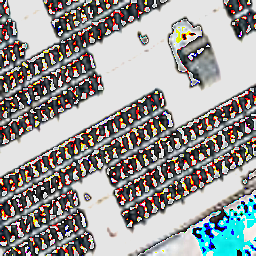

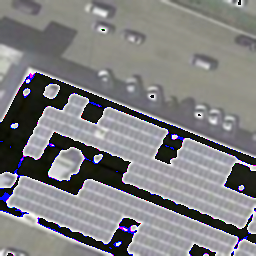

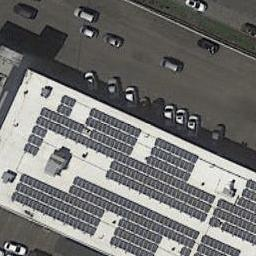

Targets: tensor([31, 18, 33, 19])


In [86]:
for batch in dataloader_train_new:
    # 'batch' contains the augmented and target images along with the label of the image
    inputs, targets = batch
    print("Target shape:", targets.shape)
    print(inputs[1].size())
    image1_np = transforms.ToPILImage()(inputs[0][0]).convert("RGB")
    display(image1_np)
    image1_np = transforms.ToPILImage()(inputs[1][0]).convert("RGB")
    display(image1_np)
    image1_np = transforms.ToPILImage()(inputs[2][0]).convert("RGB")
    display(image1_np)
    print("Targets:", targets)
    break

Loss Function

In [87]:
def nt_xent_loss(out_1, out_2, temperature):
    eps = 1e-8
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)
#     print(out_1)
    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)
    # print(sim)
    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)
    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log((pos / neg)+eps).mean()
    return loss

Specifying the Model architecture

In [88]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
up_sample_model = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(512,2048, kernel_size=1),nn.BatchNorm2d(2048),nn.ReLU())
projection_model = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
model = nn.Sequential(resnet18,up_sample_model,projection_model)

In [90]:
dummy_input = torch.randn((4, 3, 256, 256))
# print(model(dummy_input))

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [92]:
device_of_model = next(model.parameters()).device
print("Model is on:", device_of_model)

Model is on: cuda:0


In [93]:
optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [94]:
from tqdm import tqdm

SimCLR Trainig 

In [95]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 4
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/4:   0%|          | 0/9120 [00:00<?, ?it/s]

In [96]:
epochs=4
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[0] = t_in1[0].to(device)
    t_in1[1] = t_in1[1].to(device)
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    # print(t_in1.size())
    # print(t_in2.size())
    output1=model(t_in1[0])
    output2=model(t_in1[1])
#     print(output1)
    model.zero_grad()
    loss=nt_xent_loss(output1,output2,0.5)
#     print(loss)
    net_loss+=loss.item()
    loss.backward()
    optimizer.step()
    pbar.update(1)
  scheduler.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  model.eval()
  eval_acc_temp=0
  eval_acc=0
  eval_steps=0

  for batch in dataloader_val:
      # batch=tuple(t.to(device) for t in batch)
      t_in1,t_labels=batch
      t_in1[0] = t_in1[0].to(device)
      t_in1[1] = t_in1[1].to(device)
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)

      output1=model(t_in1[0])
      output2=model(t_in1[1])
      # print(output1)
      eval_acc_temp=nt_xent_loss(output1,output2,0.5)
      eval_acc+=eval_acc_temp.item()
      eval_steps+=1
      acc=eval_acc/eval_steps
  print("validation loss is "+str(acc))
pbar.close()



training1/4


Epoch 1/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [1/4] - Loss: 0.4344
Validation
validation loss is 0.9435369087254482


training2/4


Epoch 2/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [2/4] - Loss: 0.2447
Validation
validation loss is 0.6483448073006002


training3/4


Epoch 3/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [3/4] - Loss: 0.1783
Validation
validation loss is 0.5472159279614157


training4/4


Epoch 4/4:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [4/4] - Loss: 0.1651
Validation
validation loss is 0.6075935572601147


Linear Evaluation 

In [97]:
for param in resnet18.parameters():
    param.requires_grad = False

Classification Layer

In [98]:
classification_layer=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))

In [99]:
dummy_input = torch.randn((16,512,1,1))
# print(classification_layer(dummy_input).size())

In [100]:
final_model = nn.Sequential(resnet18,classification_layer)

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = final_model.to(device)
summary(final_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [102]:
def ce(out,label):
    return F.cross_entropy(out,label)

In [103]:
optimizer2 = optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)

In [104]:
epochs = 11
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/11:   0%|          | 0/25080 [00:00<?, ?it/s]

In [105]:
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  final_model.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train_new, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    output = final_model(t_in1[2])
    final_model.zero_grad()
    loss=ce(output,t_labels)
    net_loss+=loss.item()
    loss.backward()
    optimizer2.step()
    pbar.update(1)
  scheduler2.step()
  avg_epoch_loss=net_loss/len(dataloader_train_new)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  final_model.eval()
  eval_loss_temp=0
  eval_loss=0
  eval_steps=0
  correct_pred = 0
  total_pred = 0
  accuracy = 0
  for batch in dataloader_val_new:
      t_in1,t_labels=batch
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)
      output = final_model(t_in1[2])
      # print(output1)
      eval_loss_temp=ce(output,t_labels)
      eval_loss+=eval_loss_temp.item()
      eval_steps+=1
      acc=eval_loss/eval_steps
      _,predicted_class = torch.max(output,1)
      correct_pred += (predicted_class == t_labels).sum().item()
      total_pred += t_labels.size(0)
  print("Validation loss is "+str(acc))
  accuracy = (correct_pred/total_pred)*100
  print("Validation accuracy is "+str(accuracy)+"%")
pbar.close()



training1/11


Epoch 1/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [1/11] - Loss: 1.8448
Validation
Validation loss is 0.5144551099081965
Validation accuracy is 86.51315789473685%


training2/11


Epoch 2/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [2/11] - Loss: 0.5959
Validation
Validation loss is 0.35590566326036904
Validation accuracy is 89.47368421052632%


training3/11


Epoch 3/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [3/11] - Loss: 0.4836
Validation
Validation loss is 0.4428766744439551
Validation accuracy is 87.17105263157895%


training4/11


Epoch 4/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [4/11] - Loss: 0.4081
Validation
Validation loss is 0.4204927495015191
Validation accuracy is 88.81578947368422%


training5/11


Epoch 5/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [5/11] - Loss: 0.3181
Validation
Validation loss is 0.3609680734352639
Validation accuracy is 89.80263157894737%


training6/11


Epoch 6/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [6/11] - Loss: 0.2465
Validation
Validation loss is 0.32381352992065093
Validation accuracy is 91.77631578947368%


training7/11


Epoch 7/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [7/11] - Loss: 0.1840
Validation
Validation loss is 0.2620997017790949
Validation accuracy is 93.42105263157895%


training8/11


Epoch 8/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [8/11] - Loss: 0.1706
Validation
Validation loss is 0.2614476758080137
Validation accuracy is 92.76315789473685%


training9/11


Epoch 9/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [9/11] - Loss: 0.1541
Validation
Validation loss is 0.26172922605033627
Validation accuracy is 92.76315789473685%


training10/11


Epoch 10/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [10/11] - Loss: 0.1496
Validation
Validation loss is 0.2670182011124062
Validation accuracy is 92.43421052631578%


training11/11


Epoch 11/11:   0%|          | 0/228 [00:00<?, ?it/s]

Epoch [11/11] - Loss: 0.1215
Validation
Validation loss is 0.30361882877586094
Validation accuracy is 92.43421052631578%


In [106]:
for batch in dataloader_train_new:
    img,label = batch
    img[2] = img[2].to(device)
    label = label.to(device)
    out1 = final_model(img[2])
    _,predicted_class = torch.max(out1,1)
    print(predicted_class)
    print(label)
    break

tensor([ 7, 37, 18, 19], device='cuda:0')
tensor([ 7, 37, 18, 19], device='cuda:0')


In [107]:
print("Test")
final_model.eval()
test_loss_temp=0
test_loss=0
test_steps=0
correct_pred = 0
total_pred = 0
accuracy = 0
for batch in dataloader_test_new:
  # batch=tuple(t.to(device) for t in batch)
  t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
  t_in1[2] = t_in1[2].to(device)
  t_labels = t_labels.to(device)
  output = final_model(t_in1[2])
  # print(output1)
  test_loss_temp=ce(output,t_labels)
  test_loss+=test_loss_temp.item()
  test_steps+=1
  acc=test_loss/test_steps
  _,predicted_class = torch.max(output,1)
  correct_pred += (predicted_class == t_labels).sum().item()
  total_pred += t_labels.size(0)
print("Test loss is "+str(acc))
accuracy = (correct_pred/total_pred)*100
print("Test accuracy is "+str(accuracy)+"%")

Test
Test loss is 0.23567803296306297
Test accuracy is 93.75%


In [108]:
resnet18_2 = torchvision.models.resnet18(pretrained=True)
resnet18_2 = nn.Sequential(*list(resnet18_2.children())[:-1])
up_sample_model_2 = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(512,2048, kernel_size=1),nn.BatchNorm2d(2048),nn.ReLU())
projection_model_2 = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(2048),nn.Linear(2048,2048,bias=True),nn.ReLU(),nn.Linear(2048,128,bias=False))
model_2 = nn.Sequential(resnet18_2,up_sample_model_2,projection_model_2)

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = model_2.to(device)
summary(model_2, input_size=(3, 256, 256))
device_of_model = next(model_2.parameters()).device
print("Model is on:", device_of_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [110]:
for param in resnet18_2.parameters():
    param.requires_grad = True
classification_layer_2=nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),Flatten(),nn.BatchNorm1d(512),nn.Linear(512,512,bias=True),nn.ReLU(),nn.Linear(512,38,bias=False))

In [111]:
final_model_2 = nn.Sequential(resnet18_2,classification_layer_2)

In [112]:
optimizer2 = optim.Adam(final_model_2.parameters(), lr=0.000001, weight_decay=1e-6)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=10, eta_min=0)

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model_2 = final_model_2.to(device)
summary(final_model_2, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [114]:
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook for Jupyter environments
epochs = 11
no = 0
a = 0
losses = []
# Create a single progress bar for the entire training loop
pbar = tqdm(total=len(dataloader_train) * epochs, desc=f"Epoch {no + 1}/{epochs}")

Epoch 1/11:   0%|          | 0/25080 [00:00<?, ?it/s]

In [ ]:
no=0
a=0
losses=[]
for epoch in range(epochs):
  loss=0
  net_loss=0
  final_model_2.train()
  print("\n")
  print("training"+str(no+1)+"/"+str(epochs))  # Print epoch information
  for step, batch in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")):
    t_in1,t_labels=batch
    t_in1[2] = t_in1[2].to(device)
    t_labels = t_labels.to(device)
    output = final_model_2(t_in1[2])
    final_model_2.zero_grad()
    loss=ce(output,t_labels)
    net_loss+=loss.item()
    loss.backward()
    optimizer2.step()
    pbar.update(1)
  scheduler2.step()
  avg_epoch_loss=net_loss/len(dataloader_train)
  losses.append(avg_epoch_loss)
  no+=1
  print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f}")
  pbar.set_postfix_str("Validation")
  print("Validation")
  final_model_2.eval()
  eval_loss_temp=0
  eval_loss=0
  eval_steps=0
  correct_pred = 0
  total_pred = 0
  accuracy = 0
  for batch in dataloader_val:
      t_in1,t_labels=batch
      t_in1[2] = t_in1[2].to(device)
      t_labels = t_labels.to(device)
      output = final_model_2(t_in1[2])
      # print(output1)
      eval_loss_temp=ce(output,t_labels)
      eval_loss+=eval_loss_temp.item()
      eval_steps+=1
      acc=eval_loss/eval_steps
      _,predicted_class = torch.max(output,1)
      correct_pred += (predicted_class == t_labels).sum().item()
      total_pred += t_labels.size(0)
  print("Validation loss is "+str(acc))
  accuracy = (correct_pred/total_pred)*100
  print("Validation accuracy is "+str(accuracy)+"%")
pbar.close()



training1/11


Epoch 1/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [1/11] - Loss: 3.5329
Validation
Validation loss is 3.331505590049844
Validation accuracy is 23.486842105263158%


training2/11


Epoch 2/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [2/11] - Loss: 3.3112
Validation
Validation loss is 3.040042478473563
Validation accuracy is 49.76973684210526%


training3/11


Epoch 3/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [3/11] - Loss: 3.1018
Validation
Validation loss is 2.765524755653582
Validation accuracy is 61.578947368421055%


training4/11


Epoch 4/11:   0%|          | 0/2280 [00:00<?, ?it/s]

Epoch [4/11] - Loss: 2.9123
Validation
Validation loss is 2.534417010922181
Validation accuracy is 69.4407894736842%


training5/11


Epoch 5/11:   0%|          | 0/2280 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print("Test")
final_model_2.eval()
test_loss_temp=0
test_loss=0
test_steps=0
correct_pred = 0
total_pred = 0
accuracy = 0
for batch in dataloader_test:
  # batch=tuple(t.to(device) for t in batch)
  t_in1,t_labels=batch
#       t_in1[0] = t_in1[0].to(device)
#       t_in1[1] = t_in1[1].to(device)
  t_in1[2] = t_in1[2].to(device)
  t_labels = t_labels.to(device)
  output = final_model_2(t_in1[2])
  # print(output1)
  test_loss_temp=ce(output,t_labels)
  test_loss+=test_loss_temp.item()
  test_steps+=1
  acc=test_loss/test_steps
  _,predicted_class = torch.max(output,1)
  correct_pred += (predicted_class == t_labels).sum().item()
  total_pred += t_labels.size(0)
print("Test loss is "+str(acc))
accuracy = (correct_pred/total_pred)*100
print("Test accuracy is "+str(accuracy)+"%")